# Часть 1: Denoising score matching

## Как запусить?
<видео>

In [1]:
# # !pip install --upgrade --no-cache-dir gdown

# # COMMIT_HASH = "2180d8447bc1c62bf662505d73f60d3e0d7ff03c"
# # !if [ -d dgm_utils ]; then rm -Rf dgm_utils; fi
# !git clone https://github.com/r-isachenko/dgm_utils.git
# %cd dgm_utils
# !git checkout {COMMIT_HASH}
# !pip install ./
# %cd ./..
# !rm -Rf dgm_utils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import dgm_utils

In [4]:
from tqdm import tqdm
from typing import List, Tuple
import math
import matplotlib.pyplot as plt

import numpy as np
from sklearn.datasets import make_moons
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

## Задача 2: Сопоставление оценок с устраняющей шум для двумерных данных (4 балла)

Давайте обучим модель, которая будет генерировать распределение 2D-точек на плоскости

In [5]:
def generate_moons_data(count: int) -> tuple:
    data, labels = make_moons(n_samples=count, noise=0.1)
    data = data.astype("float32")
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    train_labels, test_labels = labels[:split], labels[split:]
    return train_data, train_labels, test_data, test_labels

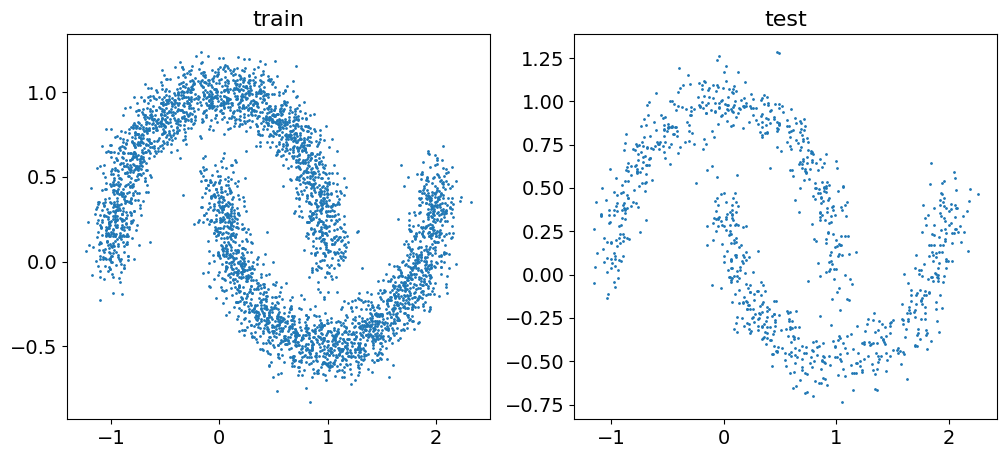

In [6]:
COUNT = 5000

train_data, train_labels, test_data, test_labels = generate_moons_data(COUNT)
dgm_utils.visualize_2d_data(train_data, test_data)

Let recall the theory of denoising score matching.

The idea is the following. We define the score function
$$
    \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}) = \nabla_{\mathbf{x}}\log p(\mathbf{x}| \boldsymbol{\theta}).
$$

Then we minimize the Fisher divergence to obtain the score function:
$$
    D_F(\pi, p) = \frac{1}{2}\mathbb{E}_{\pi}\bigl\| \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}) - \nabla_{\mathbf{x}} \log \pi(\mathbf{x}) \bigr\|^2_2 \rightarrow \min_{\boldsymbol{\theta}}
$$.

If we have the score function, we use the Langevin dynamics to sample from our model:
$$
    \mathbf{x}_{l + 1} = \mathbf{x}_l + \frac{\eta}{2} \cdot \nabla_{\mathbf{x}_l} \log p(\mathbf{x}_l | \boldsymbol{\theta}) + \sqrt{\eta} \cdot \boldsymbol{\epsilon}, \quad \boldsymbol{\epsilon} \sim \mathcal{N}(0, \mathbf{I}).
$$

But Fisher divergence is intractable and we use the noising procedure to get noised samples $\mathbf{x}_{\sigma} = \mathbf{x} + \sigma \cdot \boldsymbol{\epsilon}$.

Minimizing the Fisher divergence for the noisy samples is equivalent to the following objective:
$$
    \mathbb{E}_{q(\mathbf{x}_{\sigma})}\bigl\| \mathbf{s}_{\boldsymbol{\theta}, \sigma}(\mathbf{x}_{\sigma}) - \nabla_{\mathbf{x}_{\sigma}} \log q(\mathbf{x}_{\sigma}) \bigr\|^2_2 = \\
    = \mathbb{E}_{\pi(\mathbf{x})} \mathbb{E}_{q(\mathbf{x}_{\sigma} | \mathbf{x})}\bigl\| \mathbf{s}_{\boldsymbol{\theta}, \sigma}(\mathbf{x}_{\sigma}) - \nabla_{\mathbf{x}_{\sigma}} \log q(\mathbf{x}_{\sigma} | \mathbf{x}) \bigr\|^2_2 + \text{const}(\boldsymbol{\theta}).
$$

Here
$$
    \log q(\mathbf{x}_{\sigma} | \mathbf{x}) = - \frac{\mathbf{x}_{\sigma} - \mathbf{x}}{\sigma^2} = - \frac{\boldsymbol{\epsilon}}{\sigma}.
$$

Therefore, the objective of the denoising score matching is

$$
\mathbb{E}_{\pi(\mathbf{x})} \mathbb{E}_{q(\mathbf{x}_{\sigma} | \mathbf{x})}\bigl\| \mathbf{s}_{\boldsymbol{\theta}, \sigma}(\mathbf{x}_{\sigma}) + \frac{\boldsymbol{\epsilon}}{\sigma} \bigr\|^2_2 \rightarrow \min_{\boldsymbol{\theta}}.
$$

In [7]:
class DenoisingScoreMatcher(nn.Module):
    def __init__(
            self,
            score_model: nn.Module,
            input_shape: Tuple[int],
            sigma: float
        ):
        super().__init__()

        self.score_model = score_model
        self.input_shape = input_shape
        self.sigma = sigma

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x: torch.Tensor):
        # образец гауссового шума
        # возмущение сэмпдлв с использованием шума и сигмы
        noise = torch.randn(size=(x.size(0), *self.input_shape)).to(x)
        noisy_x = x + noise * self.sigma

        # calculate the score model
        s = self.score_model(noisy_x)


        # вычисление лосса
        # это среднеквадратичная ошибка между функцией оценки и градиентом нормального распределения
        loss = (s + noise / self.sigma).pow(2)
        return loss

    def loss(self, x: torch.Tensor):
        return {"total_loss": self(x).mean(dim=0).sum()}

    def langevin_dynamics(self, x: torch.Tensor, num_steps: int, eta: float):
        # применим динамику Ланжевена в цикле for к начальной точке x
        eta = torch.tensor(eta)
        eta_sqrt = torch.sqrt(eta)
        
        for _ in range(num_steps):
            x = x + eta / 2 * self.score_model(x) + eta_sqrt * torch.randn(size=(x.size(0), *self.input_shape)).to(x)
        # =====
        return x

    def sample(self, num_samples: int = 64, num_steps: int=100, eta: float = 0.01):
        with torch.no_grad():
            # будем сэмплировать x_0 из U[-1, 1]
            x0 = 2. * torch.rand_like(torch.empty(num_samples, *self.input_shape)) - 1.
            x0 = x0.to(self.device)

            # применим Ланжевеновскую динамику
            x = self.langevin_dynamics(x0, num_steps=num_steps, eta=eta)
        return x


def test_denoiser_score_matcher():
    matcher = DenoisingScoreMatcher(
        score_model=nn.Linear(2, 2),
        input_shape=(2,),
        sigma=0.1
    )
    x = torch.rand(16, 2)
    assert x.size() == matcher(x).size(), matcher(x).size()
    loss = matcher.loss(x)["total_loss"]
    assert len(loss.size()) == 0
    assert list(matcher.sample(4).size()) == [4, 2]


test_denoiser_score_matcher()

Это все!

А теперь мы готовы обучать нашу модель.

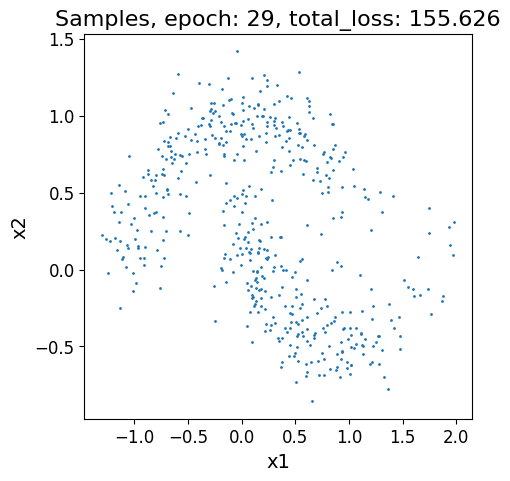

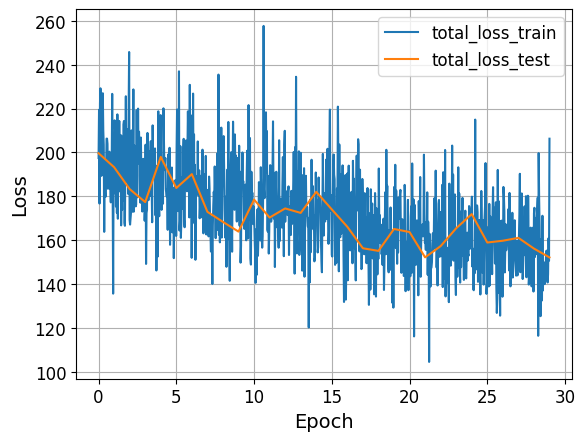

End of the training



In [8]:
BATCH_SIZE = 128  # any adequate value
EPOCHS = 30  # > 50
LR = 1e-2  # > 1e-3
HIDDEN_SIZE = 64  # > 32
SIGMA = 0.1  # 0.01 < x < 1.0

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)


score_model = nn.Sequential(
    nn.Linear(2, HIDDEN_SIZE),
    nn.SiLU(),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
    nn.SiLU(),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
    nn.SiLU(),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
    nn.SiLU(),
    nn.Linear(HIDDEN_SIZE, 2)
)

matcher = DenoisingScoreMatcher(
    score_model=score_model, input_shape=(2,), sigma=SIGMA
)


optimizer = torch.optim.Adam(matcher.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

dgm_utils.train_model(
    matcher,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE,
    n_samples=512,
)
print()

Let sample from our model. Experiment with number of steps and $\eta$ for Langevin dynamics.

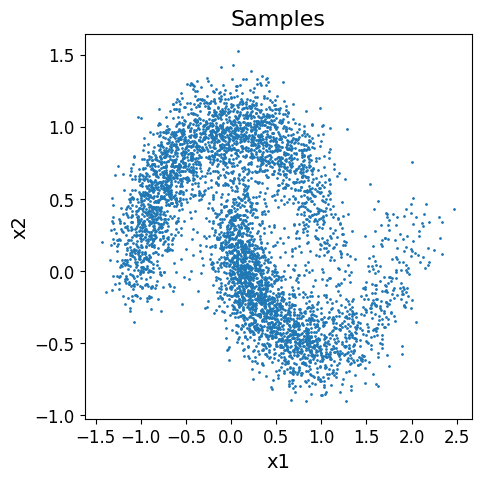

In [9]:
# ====
# your code
# choose these parameters
NUM_STEPS = 100
ETA = 0.01
# ====

torch.random.manual_seed(0)
samples = matcher.sample(num_samples=5000, num_steps=NUM_STEPS, eta=ETA).cpu()

dgm_utils.visualize_2d_samples(samples, title="Samples")

### Визуализируем как исходное распределение переходит в целевое

In [47]:
from IPython.display import clear_output
from pathlib import Path
import re
import os
import shutil


dst_root = Path("images/dsm_v4")
shutil.rmtree(dst_root, ignore_errors=True)
dst_root.mkdir(parents=True, exist_ok=True)


min_val = 0.0001
max_val = 0.01
vals = torch.sigmoid(torch.linspace(-7, 4, 120)).numpy()
vals = (vals - vals.min()) / (vals.max() - vals.min()) * (max_val - min_val) + min_val

In [45]:
for i, eta in tqdm(enumerate(vals), total=len(vals)):
    torch.random.manual_seed(0)
    samples = matcher.sample(num_samples=5000, num_steps=NUM_STEPS, eta=eta).cpu()
    dgm_utils.visualize_2d_samples(samples, title="Samples", show=False)
    
    plt.xlim(-1.75, 2.25)
    plt.ylim(-2, 2)
    
    path = Path(dst_root / f"{i:04d}.png")
    plt.savefig(path)
    plt.close()
    shutil.copy(path, dst_root / f"{2 * len(vals) - i:04d}.png")

  2%|▏         | 2/120 [00:00<00:21,  5.54it/s]

100%|██████████| 120/120 [00:23<00:00,  5.20it/s]


gifski created /home/akkirr/lecture_tretyakovka/gifs/dsm2.gif                   

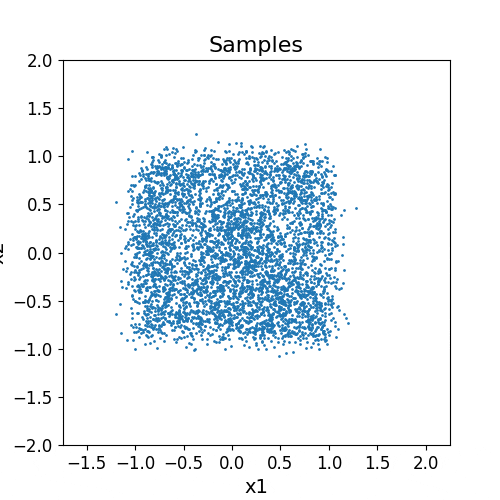

In [46]:
! gifski -o gifs/dsm2.gif images/dsm_v4/*.png
from IPython.display import Image
Image(open('gifs/dsm2.gif','rb').read())

## Task 3: Noise Conditioned Score Network for MNIST (5 pts)

Now we try to extend our model to the NCSN. It means that we have to add multiple noise scales.

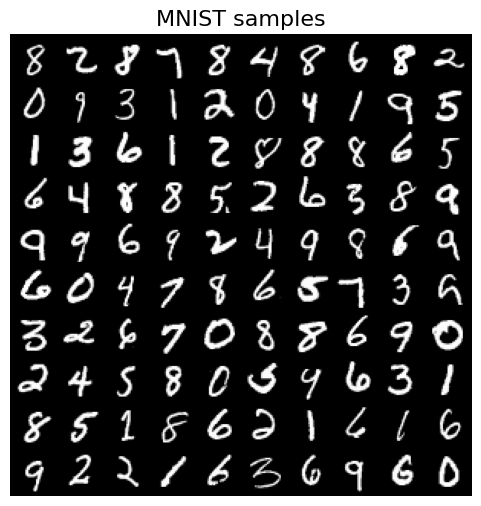

In [81]:
train_data, test_data = dgm_utils.load_dataset("mnist", flatten=False, binarize=False)
dgm_utils.visualize_images(train_data, "MNIST samples")

Here we will use the resnet-like architecture. But we encourage you to experiment with it.

The important thing here is the conditioning of the score model to noise. It means that the noise scale $\sigma$ have to be the input of the model. We will use embedding layer to make this conditioning.

In [82]:
def numel(model):
    total = 0
    for p in model.parameters():
        total += p.numel()
    return total

### Let's implement [custom unet architecture](https://huggingface.co/blog/annotated-diffusion) with weighted convs and self-attention

In [83]:
from einops import rearrange, reduce
from torch import nn, einsum
from functools import partial
from inspect import isfunction
from einops.layers.torch import Rearrange


def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

In [84]:
class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1 1", "mean")
        var = reduce(weight, "o ... -> o 1 1 1", partial(torch.var, unbiased=False))
        normalized_weight = (weight - mean) / (var + eps).rsqrt()

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ConditionedResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, num_embeddings, groups=8):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=num_embeddings, embedding_dim=dim_out * 2
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, y):
        time_emb = self.embedding(y)
        time_emb = rearrange(time_emb, "b c -> b c 1 1")
        scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)

In [85]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [86]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)
    
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x
    
def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding=1),
    )


def Downsample(dim, dim_out=None):
    # No More Strided Convolutions or Pooling
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1),
    )


In [87]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        self_condition=False,
        resnet_block_groups=4,
        num_embeddings=None,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(
            input_channels, init_dim, 1, padding=0
        )  # changed to 1 and 0 from 7,3

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ConditionedResnetBlock, groups=resnet_block_groups)

        # time embeddings
        # time_dim = dim * 4

        # self.time_mlp = nn.Sequential(
        #     SinusoidalPositionEmbeddings(dim),
        #     nn.Linear(dim, time_dim),
        #     nn.GELU(),
        #     nn.Linear(time_dim, time_dim),
        # )

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, num_embeddings=num_embeddings),
                        block_klass(dim_in, dim_in, num_embeddings=num_embeddings),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        (
                            Downsample(dim_in, dim_out)
                            if not is_last
                            else nn.Conv2d(dim_in, dim_out, 3, padding=1)
                        ),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, num_embeddings=num_embeddings)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, num_embeddings=num_embeddings)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(
                            dim_out + dim_in, dim_out, num_embeddings=num_embeddings
                        ),
                        block_klass(
                            dim_out + dim_in, dim_out, num_embeddings=num_embeddings
                        ),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        (
                            Upsample(dim_out, dim_in)
                            if not is_last
                            else nn.Conv2d(dim_out, dim_in, 3, padding=1)
                        ),
                    ]
                )
            )

        self.out_dim = default(out_dim, channels)

        self.final_res_block = block_klass(dim * 2, dim, num_embeddings=num_embeddings)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, t, x_self_cond=None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim=1)

        x = self.init_conv(x)
        r = x.clone()

        # t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)


def test_conditioned_resnet():
    model = Unet(
        dim=28,
        channels=1,
        dim_mults=(1, 2, 4),
        num_embeddings=2
    )
    x = torch.rand((1, 1, 28, 28))
    y = torch.zeros(size=(1,), dtype=torch.long)
    out1 = model(x, y)
    y = torch.ones(size=(1,), dtype=torch.long)
    out2 = model(x, y)
    assert not np.allclose(out1.detach().numpy(), out2.detach().numpy())


test_conditioned_resnet()

Now lets define the main model.

We will use the sequence of the noise levels: $\sigma_1 < \sigma_2 < \dots < \sigma_T$. In this task it will be the geometric progression.
And we will perturb the original data with the different noise levels to obtain 
$$
\mathbf{x}_t = \mathbf{x} + \sigma_t \cdot \boldsymbol{\epsilon}, \quad \mathbf{x}_t \sim q(\mathbf{x}_t). 
$$

Our training objective:
$$
    \sum_{t=1}^T \frac{\sigma_t^2}{\sigma_T^2} \mathbb{E}_{\pi(\mathbf{x})} \mathbb{E}_{q(\mathbf{x}_t | \mathbf{x})}\bigl\| \mathbf{s}_{\boldsymbol{\theta}, \sigma_t}(\mathbf{x}_t) - \nabla_{\mathbf{x}_{\sigma}} \log q(\mathbf{x}_t | \mathbf{x}) \bigr\|^2_2 \rightarrow \min_{\boldsymbol{\theta}}
$$
But instead of doing the honest summation we will sample one timestamp for each sample.

We will use annealed Langevin dynamics to sample from our model:
1. Sample $\mathbf{x}_0 \sim \mathcal{N}(0, \sigma_T^2 \cdot \mathbf{I}) \approx q(\mathbf{x}_T)$.
2. Apply $L$ steps of Langevin dynamic
$$
    \mathbf{x}_l = \mathbf{x}_{l-1} + \frac{\eta_t}{2} \cdot \mathbf{s}_{\boldsymbol{\theta}, \sigma_t}(\mathbf{x}_{l - 1}) + \sqrt{\eta_t} \cdot \boldsymbol{\epsilon}_l.
$$
3. Update $\mathbf{x}_0 := \mathbf{x}_L$ and choose the next $\sigma_t$.
4. Repeat it for all sigmas.

**Note:** use the following formula for $\eta_t = \epsilon \cdot \frac{\sigma_t^2}{\sigma_T^2}$ ($\epsilon$ is a small number that is a hyperparameter of the sampling).

In [130]:
class NoiseConditionedScoreNetwork(nn.Module):
    def __init__(
            self,
            score_model: nn.Module,
            input_shape: Tuple[int],
            sigmas: List[float]
        ):
        super().__init__()

        self.score_model = score_model
        self.input_shape = input_shape
        self.register_buffer("sigmas", torch.FloatTensor(sorted(sigmas, reverse=True)))

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x: torch.Tensor):
        self.sigmas = self.sigmas.to(self.device)
        batch_size = x.shape[0]
        # ====
        # your code
        # sample gaussian noise
        # sample timestamps for each datapoint in the batch
        # choose sigmas for these datapoints
        # add noises to the x samples
        noise = torch.randn(size=x.shape).to(self.device)
        timesteps = torch.randint(low=0, high=len(self.sigmas), size=(x.size(0),)).to(self.device)
        sigmas = self.sigmas[timesteps].reshape(x.size(0), 1, 1, 1).to(self.device)
        
        # print(x.shape, sigmas.shape, noise.shape, timesteps.shape)
        noisy_x = x + sigmas * noise
        # =====

        # calculate the score model
        s = self.score_model(noisy_x, timesteps)

        # ====
        # your code
        # compute the loss
        # it is mse between score function and gradient of the normal distribution (do not forget the coefficient before the mse)
        
        loss = (s + noise / sigmas).pow(2) * sigmas.pow(2) / self.sigmas[0].pow(2)
        
        # =====
        return loss

    def loss(self, x: torch.Tensor):
        return {"total_loss": self(x).mean(dim=0).sum()}

    def annealed_langevin_dynamics(self, x: torch.Tensor, num_steps: int, eps: float):
        # =====
        # your code
        # here we will have 2 cycles: one for sigmas, one for Langevin sampling
        # start with the largest sigma, apply Langevin dynamic for it and move to the next sigma
        
        for t, s in enumerate(self.sigmas):
            timesteps = torch.fill(torch.empty(x.size(0), dtype=torch.int), t).to(self.device)
            sigmas = torch.fill(torch.empty(x.size(0), 1, 1, 1), s).to(self.device)
            eta = eps * sigmas.pow(2) / self.sigmas[0].pow(2)
            eta_sqrt = torch.sqrt(eta)
            for _ in range(num_steps):
                x = x + eta / 2 * self.score_model(x, timesteps) + eta_sqrt * torch.randn(size=x.shape).to(self.device)
        
        # =====
        return x * 0.5 + 0.5

    def sample(self, num_samples: int = 64, num_steps: int=100, eps: float = 0.1):
        with torch.no_grad():
            # we sample x_0 from U[-1, 1]
            x0 = 2. * torch.rand_like(torch.empty(num_samples, *self.input_shape)) - 1.
            x0 = x0.to(self.device)

            # run langevine dynamics
            x = self.annealed_langevin_dynamics(x0, num_steps=num_steps, eps=eps)
        return x


def test_ncsn():
    class DummyConditionedMLP(nn.Module):
        def __init__(self):
            super().__init__()
            self.layer = nn.Conv2d(1, 1, 1)
            self.emb = nn.Embedding(1, 1)

        def forward(self, x: torch.Tensor, y: torch.Tensor):
            return self.layer(x) + self.emb(y).view(x.size(0), 1, 1, 1)


    ncsn = NoiseConditionedScoreNetwork(
        score_model=DummyConditionedMLP(),
        input_shape=(1, 28, 28),
        sigmas=[0.1]
    )
    x = torch.rand(16, 1, 28, 28)
    assert x.size() == ncsn(x).size()
    loss = ncsn.loss(x)["total_loss"]
    assert len(loss.size()) == 0
    assert list(ncsn.sample(4).size()) == [4, 1, 28, 28]


test_ncsn()

In [131]:
L = 10
# ====
# your code
# choose these parameters
SIGMA_MIN = 0.01
SIGMA_MAX = 0.8
# ====
q = (SIGMA_MAX / SIGMA_MIN) ** (1 / (L - 1))
SIGMAS = [SIGMA_MIN * q**i for i in range(0, L)]
print(SIGMAS)

[0.01, 0.01627250609936924, 0.026479445475400917, 0.04308869380063767, 0.07011610326847302, 0.11409647181002307, 0.1856635533445111, 0.3021211304229124, 0.4916267937555172, 0.7999999999999997]


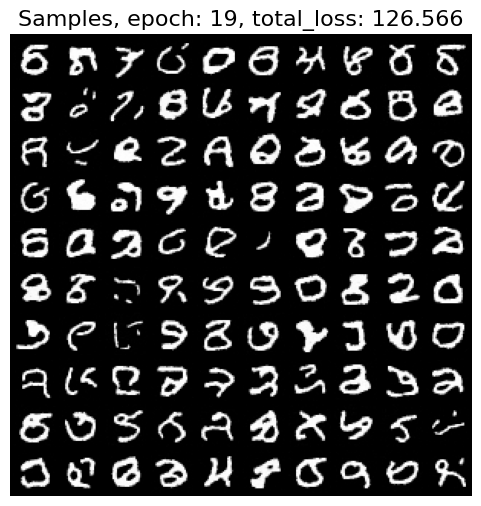

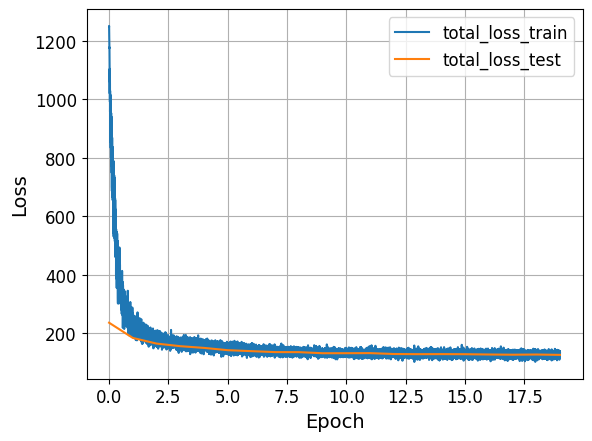

End of the training


In [141]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 64  # any adequate value
LR = 1e-4  # <= 1e-3
EPOCHS = 20  # <= 30
N_FILTERS = 32  # < 128
DIM_MULTS = (1, 2, 4)  # < 8
# ====

train_loader = data.DataLoader(2 * train_data - 1, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(2 * test_data - 1, batch_size=BATCH_SIZE, shuffle=True)

score_model = Unet(
    dim=N_FILTERS, channels=1, dim_mults=DIM_MULTS, num_embeddings=len(SIGMAS)
)

ncsn = torch.compile(NoiseConditionedScoreNetwork(
    score_model=score_model,
    input_shape=(1, 28, 28),
    sigmas=SIGMAS,
))

# ====
# your code
# choose any optimizer/scheduler as you want
optimizer = torch.optim.Adam(ncsn.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
# ====

# train
dgm_utils.train_model(
    ncsn,
    train_loader,
    test_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    device=DEVICE,
)

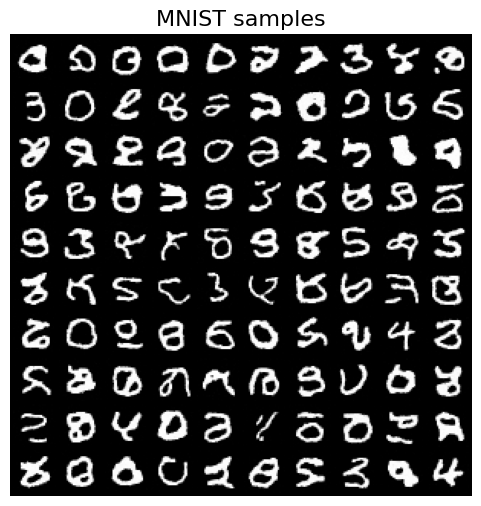

In [146]:
# ====
# your code
# choose these parameters
NUM_STEPS = 100
EPS = 0.11
# ====

samples = ncsn.sample(100, num_steps=NUM_STEPS, eps=EPS).cpu()
samples_norm = torch.clamp(samples, 0.0, 1.0)
dgm_utils.show_samples(samples_norm, "MNIST samples")